In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1653488277804_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
mpl.rcParams['figure.figsize'] = (30, 10) # use bigger graphs
def timeseries_plot(df, mnemonics, metrics):
    ax = None
    for mnemonic in mnemonics:
        for metric in metrics:
            selected = df[df.Mnemonic == mnemonic][['Date', metric]].copy()
            selected.index = selected['Date']
            selected = selected.sort_index()
            del selected['Date']
            ax = selected.plot( ax = ax)
            plt.ylabel('Price')
            
def exportData(data,path):
    data.write.mode("overwrite").csv(path)

def loadExportedData(path, header = True, clean = False):
    df_raw = spark.read.load(    
                         path,
                         format="csv", 
                         header=header, 
                         pathGlobFilter="*.csv",
                         recursiveFileLookup=True)
    
    if(not header):
        if not clean:
            df_raw = df_raw.withColumnRenamed("_c0","Date").withColumnRenamed("_c1","Mnemonic").withColumnRenamed("_c2","StartPrice").withColumnRenamed("_c3","EndPrice").withColumnRenamed("_c4","MinPrice").withColumnRenamed("_c5","MaxPrice").withColumnRenamed("_c6","TradedVolume").withColumnRenamed("_c7","Daily Return").withColumnRenamed("_c8","Daily Swing Price").withColumnRenamed("_c9","prediction")
            df_raw = (df_raw.withColumn('StartPrice', col('StartPrice').cast(DoubleType()))
                            .withColumn('MaxPrice', col('MaxPrice').cast(DoubleType()))
                            .withColumn('MinPrice', col('MinPrice').cast(DoubleType()))
                            .withColumn('EndPrice', col('EndPrice').cast(DoubleType()))
                            .withColumn('TradedVolume', col('TradedVolume').cast(DoubleType()))
                            .withColumn('Daily Return', col('Daily Return').cast(DoubleType()))
                            .withColumn('Daily Swing Price', col('TradedVolume').cast(DoubleType()))
                            .withColumn('prediction', col('prediction').cast(DoubleType())))
        else:
            df_raw = df_raw.withColumnRenamed("_c0","Date").withColumnRenamed("_c1","Mnemonic").withColumnRenamed("_c2","StartPrice").withColumnRenamed("_c3","EndPrice").withColumnRenamed("_c4","MinPrice").withColumnRenamed("_c5","MaxPrice").withColumnRenamed("_c6","TradedVolume").withColumnRenamed("_c7","Daily Return").withColumnRenamed("_c8","Daily Swing Price")
            df_raw = (df_raw.withColumn('StartPrice', col('StartPrice').cast(DoubleType()))
                        .withColumn('MaxPrice', col('MaxPrice').cast(DoubleType()))
                        .withColumn('MinPrice', col('MinPrice').cast(DoubleType()))
                        .withColumn('EndPrice', col('EndPrice').cast(DoubleType()))
                        .withColumn('TradedVolume', col('TradedVolume').cast(DoubleType()))
                        .withColumn('Daily Return', col('Daily Return').cast(DoubleType()))
                        .withColumn('Daily Swing Price', col('TradedVolume').cast(DoubleType())))
        
        
    df_raw.printSchema()
    df_raw.show()
    print(df_raw.count())
    return df_raw        
            
def loadData(path, header = True):
    df_raw = spark.read.load(    
                         path,
                         format="csv", 
                         header=header, 
                         pathGlobFilter="*.csv",
                         recursiveFileLookup=True)
    
    if(not header):
        df_raw = df_raw.withColumnRenamed("_c0","ISIN").withColumnRenamed("_c1","Mnemonic").withColumnRenamed("_c2","SecurityDesc").withColumnRenamed("_c3","SecurityType").withColumnRenamed("_c4","Currency").withColumnRenamed("_c5","SecurityID").withColumnRenamed("_c6","Date").withColumnRenamed("_c7","Time").withColumnRenamed("_c8","StartPrice").withColumnRenamed("_c9","MaxPrice").withColumnRenamed("_c10","MinPrice").withColumnRenamed("_c11","EndPrice").withColumnRenamed("_c12","TradedVolume").withColumnRenamed("_c13","NumberOfTrades")
        
        
    df_raw.printSchema()
    df_raw.show()
    print(df_raw.count())
    return df_raw

def analyseData(data):
    columns = data.columns
    for cl in columns:
        data.describe(cl).show() 



def cleanData(data):
    df_clean = data.dropna()
    df_clean = df_clean.filter(col('SecurityType') == 'Common stock')
       
    df_clean = (df_clean.withColumn('StartPrice', col('StartPrice').cast(DoubleType()))
                        .withColumn('MaxPrice', col('MaxPrice').cast(DoubleType()))
                        .withColumn('MinPrice', col('MinPrice').cast(DoubleType()))
                        .withColumn('EndPrice', col('EndPrice').cast(DoubleType()))
                        .withColumn('TradedVolume', col('TradedVolume').cast(DoubleType())))
    
    df_clean = df_clean.drop('ISIN','SecurityDesc','SecurityType','SecurityID','NumberOfTrades')
    df_clean = df_clean.sort(col('Date'),col('Time'))

    print([data.count(), df_clean.count()])
    df_clean.show()
    return df_clean

def analyseCleanData(data):
    for cl in data.columns: 
        data.select(cl).summary().show()
        
def createNewDataframeBasedOnDays(mnemonic, df_clean):
    df_clean = df_clean.where(col('Mnemonic') == mnemonic)
    
    start_price_filter = Window.partitionBy("Date").orderBy(col("Time").asc())
    start_price = df_clean.withColumn("row",row_number().over(start_price_filter)).filter(col("row") == 1).drop("row",'MaxPrice','MinPrice','EndPrice','Currency','TradedVolume', 'Time')
    
    end_price_filter = Window.partitionBy("Date").orderBy(col("Time").desc())
    end_price = df_clean.withColumn("row",row_number().over(end_price_filter)).filter(col("row") == 1).drop("row",'Mnemonic','Currency','MaxPrice','MinPrice','StartPrice','TradedVolume', 'Time')
    
    min_prices = df_clean.groupBy('Mnemonic','Date').min('MinPrice').sort('Date').drop('Mnemonic')
    max_prices = df_clean.groupBy('Mnemonic','Date').max('MaxPrice').sort('Date').drop('Mnemonic')
    tradedVolume_days = df_clean.groupBy('Mnemonic','Date').sum('TradedVolume').sort('Date').drop('Mnemonic')
    
    df_clean = start_price.join(end_price, ["Date"]).join(min_prices, ["Date"]).join(max_prices, ["Date"]).join(tradedVolume_days, ["Date"])
    
    df_clean = df_clean.withColumnRenamed("min(MinPrice)","MinPrice").withColumnRenamed("max(MaxPrice)","MaxPrice").withColumnRenamed("sum(TradedVolume)","TradedVolume").sort('Date')
       
    
    w = Window().partitionBy().orderBy(col("Date"))
    df_clean = df_clean.withColumn("Daily Return", round((df_clean.EndPrice-lag("EndPrice").over(w))*100/lag("EndPrice").over(w),3)) 
    df_clean = df_clean.withColumn("Daily Swing Price", round((df_clean.MaxPrice-df_clean.MinPrice)*100/((df_clean.MaxPrice+df_clean.MinPrice)/2),3))
    df_clean = df_clean.na.fill(value=0, subset=["Daily Return"])   
        
    df_clean.show()
    print(df_clean.count())
    
    return df_clean
    
def splitData(data):
    df_train, df_test = data.randomSplit([0.8, 0.2], seed = 42)
    return df_train, df_test

def createVecAssembler(df_train):
    vec_assembler = VectorAssembler(inputCols=["StartPrice","Daily Return", "Daily Swing Price", "TradedVolume"], outputCol="features")
    vec_df_train = vec_assembler.transform(df_train)
    vec_df_train.select("Mnemonic", "features", "EndPrice").show(10)
    return vec_df_train,vec_assembler

def linearRegression(vec_df_train):
    lr = LinearRegression(featuresCol="features", labelCol="EndPrice")
    lr_model = lr.fit(vec_df_train)
    return lr_model

def randomForestRegressor(vec_df_train):
    rf = RandomForestRegressor(labelCol="EndPrice", featuresCol="features", numTrees = 10)
    rf_model = rf.fit(vec_df_train)
    return rf_model

def createPipeline(vec_assembler,rf,df_train,df_test):
    pipeline = Pipeline(stages=[vec_assembler, rf])
    pipeline_model = pipeline.fit(df_train)
    df_prediction = pipeline_model.transform(df_test)
    df_prediction = df_prediction.sort('Date')
    df_prediction.show(10)
    return df_prediction
    
def plotEndPriceXPredictions(df_prediction):    
    rfResult= df_prediction.toPandas()
    plt.plot(rfResult.EndPrice, rfResult.prediction, 'bo')
    plt.xlabel('EndPrice')
    plt.ylabel('Prediction')
    plt.show()
    
def printMetrics(df_prediction):
    evaluator = RegressionEvaluator(labelCol="EndPrice", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(df_prediction)
    
    evaluator = RegressionEvaluator(labelCol="EndPrice", predictionCol="prediction", metricName="mse")
    mse  = evaluator.evaluate(df_prediction)
    
    evaluator = RegressionEvaluator(labelCol="EndPrice", predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(df_prediction)
    
    evaluator = RegressionEvaluator(labelCol="EndPrice", predictionCol="prediction", metricName="mae")
    mae = evaluator.evaluate(df_prediction)
    
    evaluator = RegressionEvaluator(labelCol="EndPrice", predictionCol="prediction", metricName="var") 
    var = evaluator.evaluate(df_prediction)
    
    print("RMSE: ",rmse)
    print("MSE : ",mse)
    print("r2  : ",r2)
    print("MAE : ",mae)
    print("VAR : ",var)   
    
def plotVolatility_x_Return(data):
    rfResult= data.toPandas()
    plt.plot(rfResult["Daily Swing Price"], rfResult["Daily Return"],'o')
    plt.xlabel('Volatility [%]')
    plt.ylabel('Return [%]')
    plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#path = "s3://deutsche-boerse-xetra-pds/" # Original 
path = "s3://abdbucket22/e-2ZMZQDHBWTJG5PJ9V0T7Z68HN/Full-Xetra-Dataset/" # Our bucket
mnemonic = 'BMW'
data = loadData(path, header = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- ISIN: string (nullable = true)
 |-- Mnemonic: string (nullable = true)
 |-- SecurityDesc: string (nullable = true)
 |-- SecurityType: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- SecurityID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- StartPrice: string (nullable = true)
 |-- MaxPrice: string (nullable = true)
 |-- MinPrice: string (nullable = true)
 |-- EndPrice: string (nullable = true)
 |-- TradedVolume: string (nullable = true)
 |-- NumberOfTrades: string (nullable = true)

+------------+--------+--------------------+------------+--------+----------+----------+-----+----------+--------+--------+--------+------------+--------------+
|        ISIN|Mnemonic|        SecurityDesc|SecurityType|Currency|SecurityID|      Date| Time|StartPrice|MaxPrice|MinPrice|EndPrice|TradedVolume|NumberOfTrades|
+------------+--------+--------------------+------------+--------+----------+----------+-----+--------

In [17]:
analyseData(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+
|summary|        ISIN|
+-------+------------+
|  count|   102395909|
|   mean|        null|
| stddev|        null|
|    min|AT000000STR1|
|    max|XS2437455608|
+-------+------------+

+-------+------------------+
|summary|          Mnemonic|
+-------+------------------+
|  count|         102394860|
|   mean| 62077.48844455553|
| stddev|1345629.0180979143|
|    min|              00XJ|
|    max|               ZZA|
+-------+------------------+

+-------+--------------------+
|summary|        SecurityDesc|
+-------+--------------------+
|  count|           102395909|
|   mean|                null|
| stddev|                null|
|    min|    1+1 AG  INH O.N.|
|    max|ZYNGA INC.       ...|
+-------+--------------------+

+-------+------------+
|summary|SecurityType|
+-------+------------+
|  count|   102395909|
|   mean|        null|
| stddev|        null|
|    min|Common stock|
|    max|       Other|
+-------+------------+

+-------+---------+
|summary| Currency|
+-

In [5]:
df_clean = cleanData(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[102395909, 75088187]
+--------+--------+----------+-----+----------+--------+--------+--------+------------+
|Mnemonic|Currency|      Date| Time|StartPrice|MaxPrice|MinPrice|EndPrice|TradedVolume|
+--------+--------+----------+-----+----------+--------+--------+--------+------------+
|     AZ2|     EUR|2017-07-01|08:29|     52.77|   52.77|   52.77|   52.77|         0.0|
|    ABS2|     EUR|2017-07-01|08:29|     27.69|   27.69|   27.69|   27.69|         0.0|
|     TA1|     EUR|2017-07-01|08:29|     6.685|   6.685|   6.685|   6.685|         0.0|
|     O2C|     EUR|2017-07-01|08:29|     6.625|   6.625|   6.625|   6.625|         0.0|
|     RAW|     EUR|2017-07-01|08:29|    21.995|  21.995|  21.995|  21.995|         0.0|
|     EBO|     EUR|2017-07-01|08:29|    33.525|  33.525|  33.525|  33.525|         0.0|
|     COR|     EUR|2017-07-01|08:29|     16.92|   16.92|   16.92|   16.92|         0.0|
|     BZ6|     EUR|2017-07-01|08:29|    46.715|  46.715|  46.715|  46.715|         0.0|
|     P4N|

In [18]:
analyseCleanData(df_clean)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|          Mnemonic|
+-------+------------------+
|  count|          75088187|
|   mean| 74268.88415314967|
| stddev|1485015.2858355346|
|    min|               02M|
|    25%|             639.0|
|    50%|             639.0|
|    75%|             690.0|
|    max|               ZZA|
+-------+------------------+

+-------+--------+
|summary|Currency|
+-------+--------+
|  count|75088187|
|   mean|    null|
| stddev|    null|
|    min|     EUR|
|    25%|    null|
|    50%|    null|
|    75%|    null|
|    max|     EUR|
+-------+--------+

+-------+----------+
|summary|      Date|
+-------+----------+
|  count|  75088187|
|   mean|      null|
| stddev|      null|
|    min|2017-07-01|
|    25%|      null|
|    50%|      null|
|    75%|      null|
|    max|2022-05-13|
+-------+----------+

+-------+--------+
|summary|    Time|
+-------+--------+
|  count|75088187|
|   mean|    null|
| stddev|    null|
|    min|   00:08|
|    25%|    null|
|    50%|    null

In [6]:
df_clean_v2 = createNewDataframeBasedOnDays(mnemonic,df_clean)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+----------+--------+--------+--------+------------+------------+-----------------+
|      Date|Mnemonic|StartPrice|EndPrice|MinPrice|MaxPrice|TradedVolume|Daily Return|Daily Swing Price|
+----------+--------+----------+--------+--------+--------+------------+------------+-----------------+
|2017-07-01|     BMW|     81.28|   81.28|   81.28|   81.28|         0.0|         0.0|              0.0|
|2017-07-03|     BMW|     80.51|   83.12|    80.5|   83.52|   1305906.0|       2.264|            3.682|
|2017-07-04|     BMW|     82.55|   82.53|   82.34|   83.53|    763679.0|       -0.71|            1.435|
|2017-07-05|     BMW|     82.05|   81.48|   81.19|   82.18|   1172081.0|      -1.272|            1.212|
|2017-07-06|     BMW|      81.7|   81.34|    80.5|   82.13|   1502148.0|      -0.172|            2.005|
|2017-07-07|     BMW|      81.4|   81.26|   80.83|    81.6|    662280.0|      -0.098|            0.948|
|2017-07-10|     BMW|     81.74|   81.55|   81.18|   82.13|    7

In [7]:
path = 's3://abdbucket22/e-2ZMZQDHBWTJG5PJ9V0T7Z68HN/BMW/'
exportData(df_clean_v2, path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
path = "/home/big/ABD/Projeto/BMW"            #MV ---> correr na maquina virtual!
data = loadExportedData(path, header = False) #MV

In [ ]:
timeseries_plot(data.toPandas(), [mnemonic], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) #MV

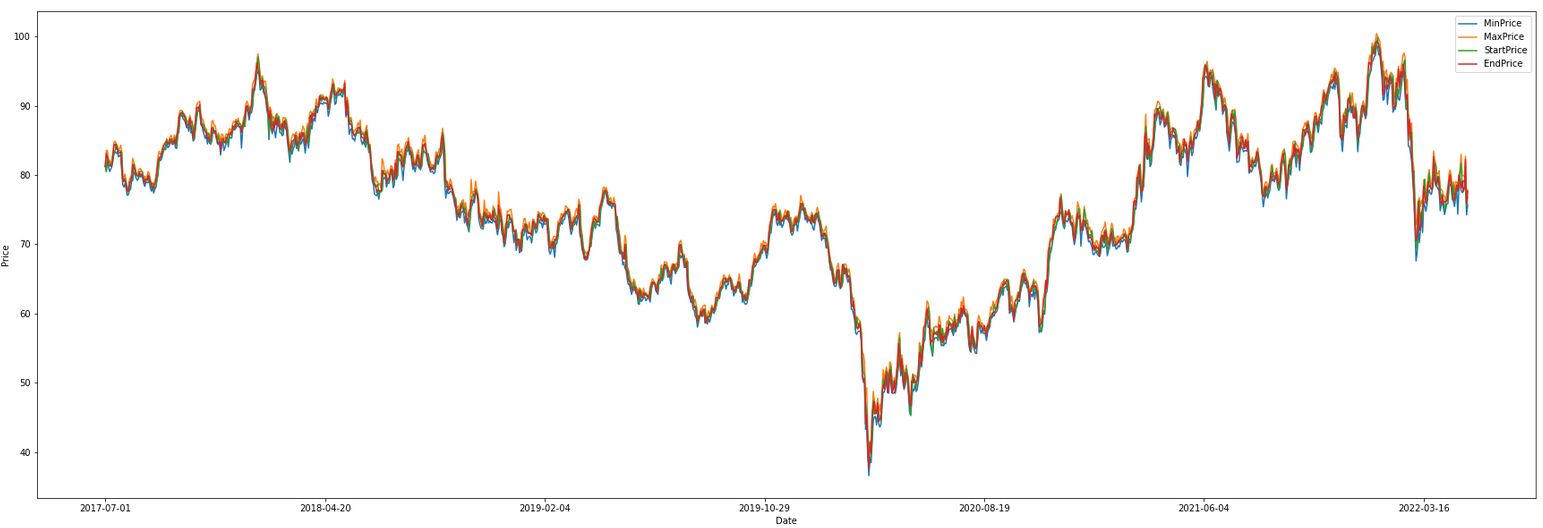

In [8]:
df_train, df_test = splitData(df_clean_v2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
vec_df_train,vec_assembler = createVecAssembler(df_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+--------+
|Mnemonic|            features|EndPrice|
+--------+--------------------+--------+
|     BMW|     (4,[0],[81.28])|   81.28|
|     BMW|[80.51,2.264,3.68...|   83.12|
|     BMW|[82.05,-1.272,1.2...|   81.48|
|     BMW|[81.7,-0.172,2.00...|   81.34|
|     BMW|[81.4,-0.098,0.94...|   81.26|
|     BMW|[82.27,1.692,1.53...|   82.93|
|     BMW|[83.55,0.154,1.81...|   84.47|
|     BMW|[84.45,-0.864,1.6...|   83.74|
|     BMW|[83.86,-0.012,1.0...|   83.73|
|     BMW|[83.48,-0.705,1.1...|   83.14|
+--------+--------------------+--------+
only showing top 10 rows

In [10]:
rf_model = randomForestRegressor(vec_df_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df_prediction = createPipeline(vec_assembler,rf_model,df_train,df_test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+----------+--------+--------+--------+------------+------------+-----------------+--------------------+-----------------+
|      Date|Mnemonic|StartPrice|EndPrice|MinPrice|MaxPrice|TradedVolume|Daily Return|Daily Swing Price|            features|       prediction|
+----------+--------+----------+--------+--------+--------+------------+------------+-----------------+--------------------+-----------------+
|2017-07-04|     BMW|     82.55|   82.53|   82.34|   83.53|    763679.0|       -0.71|            1.435|[82.55,-0.71,1.43...|83.83674890417645|
|2017-07-10|     BMW|     81.74|   81.55|   81.18|   82.13|    704184.0|       0.357|            1.163|[81.74,0.357,1.16...|82.61087485373432|
|2017-07-12|     BMW|     83.29|   84.34|   83.26|   84.78|   1555265.0|         1.7|            1.809|[83.29,1.7,1.809,...| 82.8810391055687|
|2017-07-19|     BMW|      83.5|   83.19|   82.87|   83.79|    568144.0|        0.06|            1.104|[83.5,0.06,1.104,...|84.37721046858954|

In [13]:
df_prediction.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

210

In [12]:
df_prediction = df_prediction.drop('features')
path = "s3://abdbucket22/e-2ZMZQDHBWTJG5PJ9V0T7Z68HN/Exported-Results/"
exportData(df_prediction, path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
path = "/home/big/ABD/Projeto/dataaa"         #MV
data = loadExportedData(path, header = False) #MV

In [ ]:
timeseries_plot(data.toPandas(), [mnemonic], ['EndPrice', 'prediction']) #MV

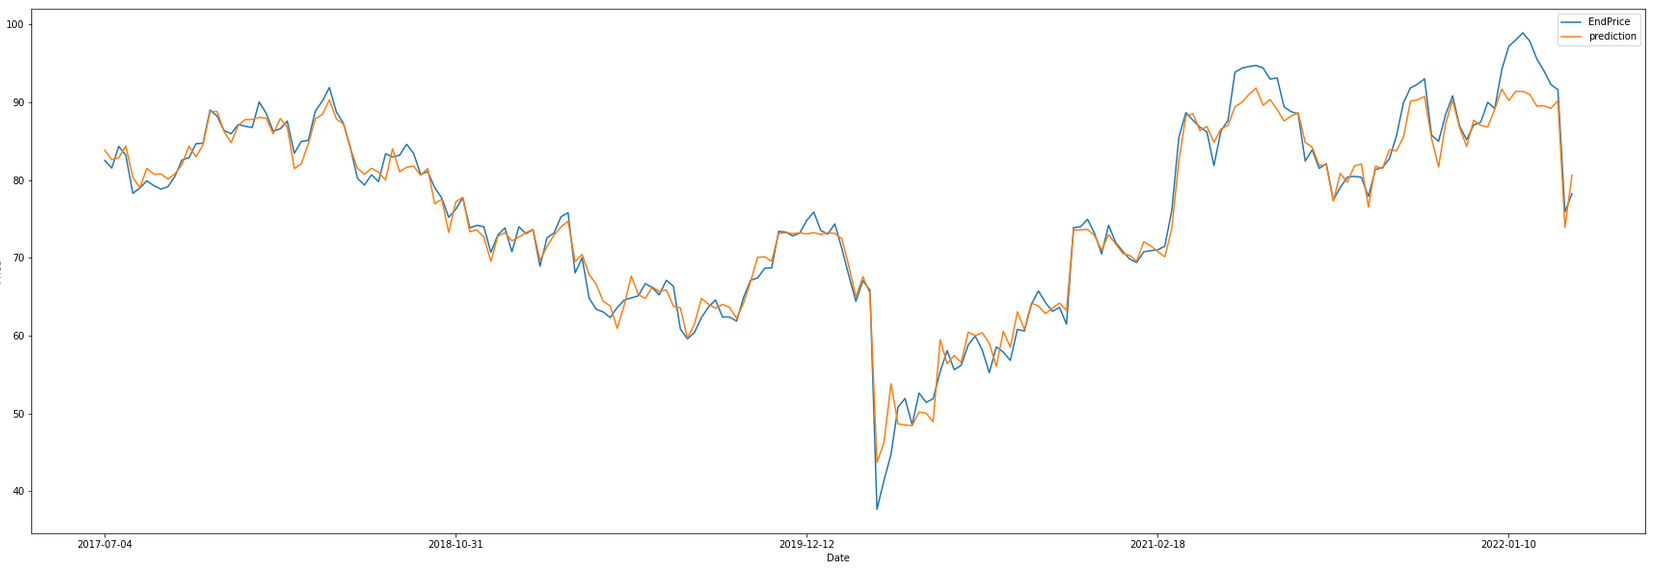

In [ ]:
plotEndPriceXPredictions(data) #MV

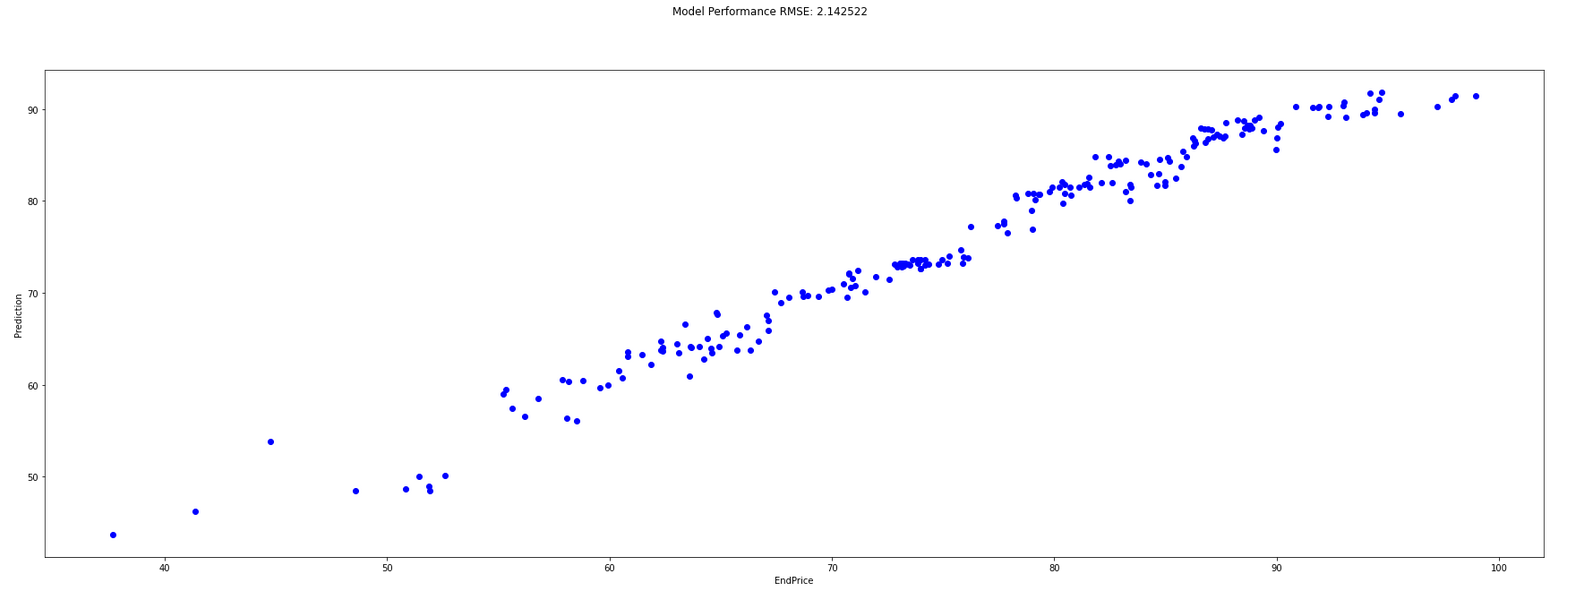

In [ ]:
plotVolatility_x_Return(data) #MV

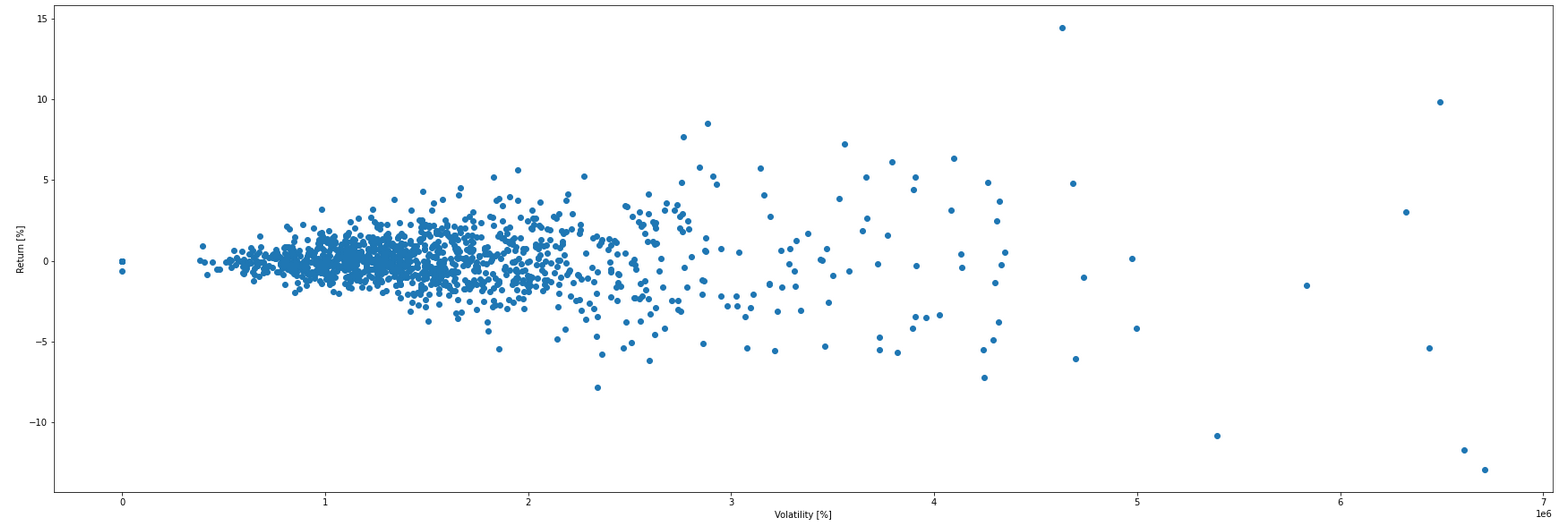

In [14]:
printMetrics(df_prediction)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE:  2.14252220417316
MSE :  4.590401395375016
r2  :  0.9689942536693391
MAE :  1.524538020688904
VAR :  125.86873608401179